
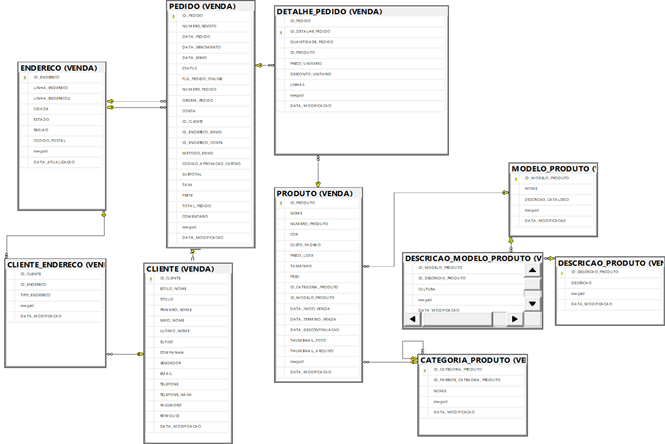

Parte 1
---

1.	Instalar e importar as bibliotecas do spark e pyspark

In [ ]:
%%sh
sudo pip install spark
sudo pip install pyspark

In [ ]:
import pandas as pd
import spark,pyspark
from pyspark.sql import *                   #Importando as bibliotecas do pyspark.sql 
from pyspark.sql import functions as f      #Importando as funções sql do spark
from pyspark.sql import types as t          #Importando os tipos de dados do spark
from datetime import datetime, date         #Biblioteca datetime

2.	Criar um spark context com o app name = “AC5 DataEng”

In [ ]:
#Criando uma Sessão do Spark (Spark Session)  #APPNAME PODEMOS COLOCAR QUALQUER NOME      
spark = SparkSession.builder.master("local").appName("Aula Impacta Pyspark").getOrCreate()

3.	Criar uma conexão com o banco de dados AdventureWorksLT2019_PT

In [ ]:
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17
sudo pip install pyodbc
sudo pip install sqlalchemy
pip install pyodbc
pip install boto3

OK
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 https://packages.microsoft.com/ubuntu/16.04/prod xenial InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic I

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key output should not be parsed (stdout is not a terminal)
100   983  100   983    0     0   3401      0 --:--:-- --:--:-- --:--:--  3413
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    79  100    79    0     0    544      0 --:--:-- --:--:-- --:--:--   544


In [ ]:
import pyodbc, pandas as pd,json,boto3,io,decimal,datetime,os,sqlalchemy

In [ ]:
#Servidor de banco de dados
server = "sql20211.cp1ri5jswsct.us-east-1.rds.amazonaws.com" 
#Nome da base de dados
database = "AdventureWorksLT2019_PT"
#Usuario
username = "aluno"
#Senha
password = "aluno123"
#Exemplo de conexão sql usando usuario e senha
con1 = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC Driver 17 for SQL Server"
engine = sqlalchemy.create_engine(con1)
engine.connect()

4.	Ler todas as tabelas com o pandas, transformar em um dataframe do spark e gravar como parquet em uma pasta chamada “adventure” no colab. Lembrando que as tabelas estão no schema VENDA no banco de dados (VENDA.PEDIDO,VENDA.CLIENTE, etc)

In [ ]:
df = pd.read_sql("SELECT * FROM information_schema.tables",engine)
for row,i in df.iterrows():
  if i['TABLE_SCHEMA'] == 'VENDA':
    schema = i['TABLE_SCHEMA']
    tabela = i['TABLE_NAME']
    df = pd.read_sql(f"select * from {schema}.{tabela}",con = engine)
    df_spark = spark.createDataFrame(df)
    df_spark.write.mode("overwrite").parquet(f"adventure/{tabela}")
  else:
    continue

Parte 2 - Transformação de dados (TRANSFORM) - Utilize os dados gravados no colab.
---
5.	Crie um dataframe juntando as tabelas CLIENTE, PEDIDO e DETALHES_PEDIDO. Agrupando pelo id do cliente, some a quantidade pedido, valor unitário e desconto. Depois crie uma coluna chamada lucro (quantidade pedido * valor unitario) - desconto. Grave esse dataframe no formato json com o nome de “TRANSFORMACAO/PEDIDO_CLIENTE”.

In [ ]:
df_c = spark.read.parquet("/content/adventure/CLIENTE")
df_c.registerTempTable("cliente")
df_c.show()

+----------+-----------+------+-------------+---------+-----------+------+--------------------+--------------------+--------------------+-------------------+--------------------+--------+--------------------+-------------------+
|ID_CLIENTE|ESTILO_NOME|TITULO|PRIMEIRO_NOME|MEIO_NOME|ULTIMO_NOME|SUFIXO|           COMPANHIA|            VENDEDOR|               EMAIL|           TELEFONE|       TELEFONE_HASH|PASSWORD|             ROWGUID|   DATA_MODIFICACAO|
+----------+-----------+------+-------------+---------+-----------+------+--------------------+--------------------+--------------------+-------------------+--------------------+--------+--------------------+-------------------+
|         1|      false|   Mr.|      Orlando|       N.|        Gee|  null|        A Bike Store|adventure-works\p...|orlando0@adventur...|       245-555-0173|L/Rlwxzp4w7RWmEgX...|1KjXYs4=|3F5AE95E-B87D-4AE...|2005-08-01 00:00:00|
|         2|      false|   Mr.|        Keith|     null|     Harris|  null|  Progress

In [ ]:
df_dp = spark.read.parquet("/content/adventure/DETALHE_PEDIDO")
df_dp.registerTempTable("detpedido")
df_dp.show()

+---------+-----------------+-----------------+----------+--------------+-----------------+--------+--------------------+-------------------+
|ID_PEDIDO|ID_DETALHE_PEDIDO|QUANTIDADE_PEDIDO|ID_PRODUTO|PRECO_UNITARIO|DESCONTO_UNITARIO|  LINHAS|             rowguid|   DATA_MODIFICACAO|
+---------+-----------------+-----------------+----------+--------------+-----------------+--------+--------------------+-------------------+
|    71774|           110562|                1|       836|       356.898|              0.0| 356.898|E3A1994C-7A68-4CE...|2008-06-01 00:00:00|
|    71774|           110563|                1|       822|       356.898|              0.0| 356.898|5C77F557-FDB6-43B...|2008-06-01 00:00:00|
|    71776|           110567|                1|       907|          63.9|              0.0|    63.9|6DBFE398-D15D-425...|2008-06-01 00:00:00|
|    71780|           110616|                4|       905|       218.454|              0.0| 873.816|377246C9-4483-48E...|2008-06-01 00:00:00|
|    7

In [ ]:
df_p = spark.read.parquet("/content/adventure/PEDIDO")
df_p.registerTempTable("pedido")
df_p.show()

+---------+--------------+-------------------+-------------------+-------------------+------+-----------------+-------------+-------------+--------------+----------+-----------------+-----------------+-----------------+-----------------------+-----------+---------+---------+------------+----------+--------------------+-------------------+
|ID_PEDIDO|NUMERO_REVISTO|        DATA_PEDIDO|    DATA_VENCIMENTO|         DATA_ENVIO|STATUS|FLG_PEDIDO_ONLINE|NUMERO_PEDIDO| ORDEM_PEDIDO|         CONTA|ID_CLIENTE|ID_ENDERECO_ENVIO|ID_ENDERECO_CONTA|     METODO_ENVIO|CODIGO_APROVACAO_CARTAO|   SUBTOTAL|     TAXA|    FRETE|TOTAL_PEDIDO|COMENTARIO|             rowguid|   DATA_MODIFICACAO|
+---------+--------------+-------------------+-------------------+-------------------+------+-----------------+-------------+-------------+--------------+----------+-----------------+-----------------+-----------------+-----------------------+-----------+---------+---------+------------+----------+-------------------

In [ ]:
dfcli = spark.sql("select cli.id_cliente , sum (quantidade_pedido) as pedido , sum(preco_unitario) as preco, sum(desconto_unitario) as desconto, (quantidade_pedido * preco_unitario - desconto_unitario) as lucro from cliente as cli inner join pedido as pe on cli.id_cliente = pe.id_cliente inner join detpedido as det on pe.id_pedido = det.id_pedido group by cli.id_cliente , lucro")

dfcli.show()

+----------+------+--------+--------+------------------+
|id_cliente|pedido|   preco|desconto|             lucro|
+----------+------+--------+--------+------------------+
|     29796|     9|  14.694|     0.0|           132.246|
|     29796|     1| 202.332|     0.0|           202.332|
|     29796|     4|  48.594|     0.0|           194.376|
|     30113|     3| 323.994|     0.0| 971.9820000000001|
|     29653|     2| 1457.82|     0.0|            728.91|
|     29796|     4| 323.994|     0.0|          1295.976|
|     29957|    10|   2.994|     0.0|             29.94|
|     29796|    15| 29.6945|    0.05|          445.3675|
|     29929|    10|  64.788|     0.0|            161.97|
|     29485|     4|  72.894|     0.0|           291.576|
|     29929|     2|1376.994|     0.0|          2753.988|
|     30050|     3|  12.144|     0.0|            36.432|
|     30113|     7|  41.994|     0.0|293.95799999999997|
|     29546|     5|  20.994|     0.0|            104.97|
|     29653|     2|  29.994|   

6 - Crie um dataframe juntando os dados de CATEGORIA_PRODUTO, PRODUTO E MODELO_PRODUTO. Selecione as seguintes colunas,\
Nome da categoria do produto.\
Nome, número, cor, custo padrão, preço lista, tamanho e peso do produto
Nome do modelo do produto.\
Aplicando as regras abaixo:\
O início e o fim do nome do produto não pode ter espaços e tem que ter todas as letras maiúsculas.\
Concatenar um hífen e o nome da cor no final do nome do produto\
Se o tamanho vier como “M” deverá ser 49, se vier “P” deverá ser 32, se vier “L” deverá ser 52, se vier XL deverá ser 70 e ser for null deverá ser 0. Nos outros casos, mantenha o valor do tamanho.\
Criar uma coluna chamada Codigo_Produto. Essa coluna deve conter os dois primeiros dígitos do número do produto.\
Substituir o hífen no nome do modelo do produto por um espaço.\
Gravar esse dataframe como parquet com o nome de “TRANSFORMACAO/PRODUTOS”,\ particionado por categoria_produto


In [ ]:
df_cp = spark.read.parquet("/content/adventure/CATEGORIA_PRODUTO")
df_cp.registerTempTable("catproduto")
df_cp.show()

+--------------------+----------------------------+---------------+--------------------+-------------------+
|ID_CATEGORIA_PRODUTO|ID_PARENTE_CATEGORIA_PRODUTO|           NOME|             rowguid|   DATA_MODIFICACAO|
+--------------------+----------------------------+---------------+--------------------+-------------------+
|                   1|                         NaN|          Bikes|CFBDA25C-DF71-47A...|2002-06-01 00:00:00|
|                   2|                         NaN|     Components|C657828D-D808-4AB...|2002-06-01 00:00:00|
|                   3|                         NaN|       Clothing|10A7C342-CA82-48D...|2002-06-01 00:00:00|
|                   4|                         NaN|    Accessories|2BE3BE36-D9A2-4EE...|2002-06-01 00:00:00|
|                   5|                         1.0| Mountain Bikes|2D364ADE-264A-433...|2002-06-01 00:00:00|
|                   6|                         1.0|     Road Bikes|000310C0-BCC8-42C...|2002-06-01 00:00:00|
|                  

In [ ]:
df_pro = spark.read.parquet("/content/adventure/PRODUTO")
df_pro.registerTempTable("produto")
df_pro.show()

+----------+--------------------+--------------+-----+------------+-----------+-------+-------+--------------------+-----------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|ID_PRODUTO|                NOME|NUMERO_PRODUTO|  COR|CUSTO_PADRAO|PRECO_LISTA|TAMANHO|   PESO|ID_CATEGORIA_PRODUTO|ID_MODELO_PRODUTO|  DATA_INICIO_VENDA| DATA_TERMINO_VENDA|DATA_DESCONTINUACAO|      THUMBNAIL_FOTO|   THUMBNAIL_ARQUIVO|             rowguid|    DATA_MODIFICACAO|
+----------+--------------------+--------------+-----+------------+-----------+-------+-------+--------------------+-----------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|       680|HL Road Frame - B...|    FR-R92B-58|Black|     1059.31|     1431.5|     58|1016.04|                  18|                6|2002-06-01 00:00:00|         

In [ ]:
df_mp = spark.read.parquet("/content/adventure/MODELO_PRODUTO")
df_mp.registerTempTable("modproduto")
df_mp.show()

+-----------------+--------------------+--------------------+--------------------+--------------------+
|ID_MODELO_PRODUTO|                NOME|  DESCRICAO_CATALOGO|             rowguid|    DATA_MODIFICACAO|
+-----------------+--------------------+--------------------+--------------------+--------------------+
|                1|        Classic Vest|                null|29321D47-1E4C-4AA...| 2007-06-01 00:00:00|
|                2|         Cycling Cap|                null|474FB654-3C96-4CB...| 2005-06-01 00:00:00|
|                3|  Full-Finger Gloves|                null|A75483FE-3C47-4AA...| 2006-06-01 00:00:00|
|                4|  Half-Finger Gloves|                null|14B56F2A-D4AA-40A...| 2006-06-01 00:00:00|
|                5|   HL Mountain Frame|                null|FDD5407B-C2DB-49D...| 2005-06-01 00:00:00|
|                6|       HL Road Frame|                null|4D332ECC-48B3-4E0...| 2002-05-02 00:00:00|
|                7|    HL Touring Frame|                null|D60

In [ ]:
dfpro = spark.sql("select cpro.nome as Nome_Categoria,replace(concat(upper(rtrim(ltrim(pro.nome))),'-',pro.cor),'-',' ') as Nome, numero_produto, cor, custo_padrao, preco_lista,replace(replace(replace(replace(tamanho,'M',49),'XL',70),'L',52),'S', 32) as tamanho, peso, mpro.nome as nome_modelo , left(numero_produto,2) as Codigo_Produto from catproduto as cpro inner join produto as pro on cpro.id_categoria_produto = pro.id_categoria_produto inner join modproduto as mpro on pro.id_modelo_produto = mpro.id_modelo_produto ")
dfpro.show()

+--------------+--------------------+--------------+-----+------------+-----------+-------+-------+--------------------+--------------+
|Nome_Categoria|                Nome|numero_produto|  cor|custo_padrao|preco_lista|tamanho|   peso|         nome_modelo|Codigo_Produto|
+--------------+--------------------+--------------+-----+------------+-----------+-------+-------+--------------------+--------------+
|   Road Frames|HL ROAD FRAME   B...|    FR-R92B-58|Black|     1059.31|     1431.5|     58|1016.04|       HL Road Frame|            FR|
|   Road Frames|HL ROAD FRAME   R...|    FR-R92R-58|  Red|     1059.31|     1431.5|     58|1016.04|       HL Road Frame|            FR|
|       Helmets|SPORT 100 HELMET,...|     HL-U509-R|  Red|     13.0863|      34.99|   null|    NaN|           Sport-100|            HL|
|       Helmets|SPORT 100 HELMET,...|       HL-U509|Black|     13.0863|      34.99|   null|    NaN|           Sport-100|            HL|
|         Socks|MOUNTAIN BIKE SOC...|     SO-B90

In [ ]:
dfpro = dfpro.withColumn("tamanho",f.when(dfpro.tamanho.isNull(),0).otherwise(dfpro.tamanho))

In [ ]:
dfpro.write\
.format("parquet")\
.partitionBy("Nome_Categoria")\
.mode("overwrite").save("TRANSFORMACAO/PRODUTOS")

7 - Crie um dataframe trazendo as seguintes colunas das tabelas (PRODUTO,  DETALHE_PEDIDO) \
Obs: Filtrar apenas os produtos que não possuem data_termino_venda.\
● nome produto,\
● soma da quantidade_pedido\
● contagem distinta de pedido\
● data da última compra\
● data da primeira compra\
Agrupado por nome_produto  e grave como parquet com o nome de “TRANSFORMACAO/COMPRA_PRODUTO”

In [ ]:
dfpro = spark.sql("select nome, sum(quantidade_pedido), count(distinct(dped.id_pedido)) qtd_pedidos_distintos, max(pro.data_termino_venda) data_ultima_compra, min(pro.data_inicio_venda) data_primeira_compra, pro.data_termino_venda from produto as pro inner join detpedido as dped on pro.id_produto = dped.id_produto where pro.data_termino_venda is null group by nome, pro.data_termino_venda ")
dfpro.show()

+--------------------+----------------------+---------------------+------------------+--------------------+------------------+
|                nome|sum(quantidade_pedido)|qtd_pedidos_distintos|data_ultima_compra|data_primeira_compra|data_termino_venda|
+--------------------+----------------------+---------------------+------------------+--------------------+------------------+
|HL Road Frame - R...|                     3|                    2|              null| 2005-07-01 00:00:00|              null|
|Mountain-200 Blac...|                    27|                    4|              null| 2006-07-01 00:00:00|              null|
|Touring-1000 Yell...|                    12|                    6|              null| 2007-07-01 00:00:00|              null|
|Touring-1000 Blue...|                     6|                    2|              null| 2007-07-01 00:00:00|              null|
|ML Mountain Frame...|                    12|                    4|              null| 2007-07-01 00:00:00|    

8 - Crie um dataframe  trazendo as seguintes colunas das tabelas (ENDERECO,CLIENTE_ENDERECO):\
● endereco (fica na coluna linha endereço 2, caso essa coluna estiver
vazia, traga no lugar os dados da coluna linha endereço).\
● Número_endereço (pegar apenas os digitos, aplique a função do spark.sql.functions  “regexp_replace(column_name, '[^0-9]', ''))”.\
● Cidade (letras minúsculas).\
● Estado (letras maiúsculas).\
● Duas primeiras letras da Região.\
● tipo_endereço (se o valor for “Main Office”, traga como “principal” se for “shipping” traga como “entrega”). Gravar como parquet com o nome de “TRANSFORMACAO/ENDERECO_CLIENTE”, particionado por estado,cidade.


In [ ]:
df_end = spark.read.parquet("/content/adventure/ENDERECO")
df_end.registerTempTable("endereco")
df_end.show()

+-----------+--------------------+---------------+-----------+----------------+-------------+-------------+--------------------+-------------------+
|ID_ENDERECO|      LINHA_ENDERECO|LINHA_ENDERECO2|     CIDADE|          ESTADO|       REGIAO|CODIGO_POSTAL|             rowguid|   DATA_ATUALIZACAO|
+-----------+--------------------+---------------+-----------+----------------+-------------+-------------+--------------------+-------------------+
|          9|   8713 Yosemite Ct.|           null|    Bothell|      Washington|United States|        98011|268AF621-76D7-4C7...|2006-07-01 00:00:00|
|         11| 1318 Lasalle Street|           null|    Bothell|      Washington|United States|        98011|981B3303-ACA2-49C...|2007-04-01 00:00:00|
|         25|    9178 Jumping St.|           null|     Dallas|           Texas|United States|        75201|C8DF3BD9-48F0-465...|2006-09-01 00:00:00|
|         28|    9228 Via Del Sol|           null|    Phoenix|         Arizona|United States|        85004

In [ ]:
df_cliend = spark.read.parquet("/content/adventure/CLIENTE_ENDERECO")
df_cliend.registerTempTable("cliendereco")
df_cliend.show()

+----------+-----------+-------------+--------------------+-------------------+
|ID_CLIENTE|ID_ENDERECO|TIPO_ENDERECO|             rowguid|   DATA_MODIFICACAO|
+----------+-----------+-------------+--------------------+-------------------+
|     29485|       1086|  Main Office|16765338-DBE4-442...|2007-09-01 00:00:00|
|     29486|        621|  Main Office|22B3E910-14AF-4ED...|2005-09-01 00:00:00|
|     29489|       1069|  Main Office|A095C88B-D7E6-417...|2005-07-01 00:00:00|
|     29490|        887|  Main Office|F12E1702-D897-403...|2006-09-01 00:00:00|
|     29492|        618|  Main Office|5B3B3EB2-3F43-47E...|2006-12-01 00:00:00|
|     29494|        537|  Main Office|492D92B6-31AF-47E...|2005-09-01 00:00:00|
|     29496|       1072|  Main Office|0A66B0F3-24BC-414...|2007-09-01 00:00:00|
|     29497|        889|  Main Office|7E0B56FD-7324-489...|2005-07-01 00:00:00|
|     29499|        527|  Main Office|C90CB0C3-976A-407...|2006-09-01 00:00:00|
|     29502|        893|  Main Office|8A

In [ ]:
dfendc = spark.sql("select end.LINHA_ENDERECO, end.LINHA_ENDERECO2 endereco, upper(end.cidade) Cidade, upper(end.estado) Estado, left(end.regiao,2) Regiao, case when clie.tipo_endereco = 'Shipping' then 'entrega' when clie.tipo_endereco = 'Main Office' then 'principal' else 'indefinido' end as tipo_endereco from endereco as end inner join cliendereco as clie on end.id_endereco = clie.id_endereco")
dfendc = dfendc.withColumn("endereco",f.when(dfendc.endereco.isNull(),dfendc.LINHA_ENDERECO).otherwise(dfendc.endereco))
dfendc = dfendc.withColumn("Número", regexp_replace(dfendc.endereco, '[^0-9]', ''))
dfendc = dfendc.drop("LINHA_ENDERECO")
dfendc.show()

In [ ]:
dfendc.write\
.format("parquet")\
.partitionBy("Estado", "Cidade")\
.mode("overwrite").save("TRANSFORMACAO/ENDERECO_CLIENTE")